In [1]:
# To enable faster auto-complete
%config Completer.use_jedi = False

In [24]:
import sys 
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import sys
import pickle
from utils import data_augmentation
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle

font = {
    'family' : 'normal',
    'weight': 'normal',
    'size': 12
}
matplotlib.rc('font', **font)

In [3]:
# Selecting the GPU to be used 
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    # Restrict tensor flow to use GPU-1
    try:
        tf.config.experimental.set_visible_devices([], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Set GPUs before initializing
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
4 Physical GPUs 0 Logical GPU


In [4]:
# Plotting of the confusion matrix
def confusion_matrix(model, X_test, y_test, class_names):
    # Prediction on test data set -> predicting classes
    y_pred = model.predict_classes(X_test)
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
    # Normalizing the confusion matrix
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1) [:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)
    # Plotting using an heat map
    figure = plt.figure(figsize=(8,8))
    sns.set(font_scale = 2)
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Multi-output model evaluation and Plotting

## Load data without oversampling

In [5]:
# Directory of the dataset
data_dir = os.path.join(os.getcwd(), "model_data", "multi_output_axisfr")

for index1, file in enumerate(os.listdir(data_dir)):
    data = np.load(os.path.join(data_dir, file), allow_pickle=True)[()]
    
    for index2, ((axis, feed_rate), segmented_points) in enumerate(data.items()):
        
        temp_axis = np.repeat(axis, segmented_points.shape[0])[:, np.newaxis]
        temp_fr = np.repeat(feed_rate, segmented_points.shape[0])[:, np.newaxis]
    
        # part of X and y
        if index2 == 0:
            # part of y for an axis and all feed rate
            part_y_axis = temp_axis
            part_y_fr = temp_fr
            # part of X
            part_X = segmented_points
        else:
            part_y_axis = np.append(part_y_axis, temp_axis, axis=0)
            part_y_fr = np.append(part_y_fr, temp_fr, axis=0)
            part_X = np.append(part_X, segmented_points, axis=0)
            
    if index1 == 0:
        # y
        y_axis = part_y_axis
        y_fr = part_y_fr
        # X
        X = part_X
    else:
        y_axis = np.append(y_axis, part_y_axis, axis=0)
        y_fr = np.append(y_fr, part_y_fr, axis=0)
        X = np.append(X, part_X, axis=0)



## Reminding the training history and scores

In [6]:
folder_time = "2021-07-28T00:07:46.613812"

# Select item to load
history_path = os.path.join(os.getcwd(), "model_weights", "multi_output_ax-fr", folder_time, "training_history", "history.pickle")
score_path = os.path.join(os.getcwd(), "model_weights", "multi_output_ax-fr", folder_time, "training_history", "score.pickle")

with open(history_path, "rb") as fh:
    history = pickle.load(fh)
    
with open(score_path, "rb") as fh:
    score = pickle.load(fh)

In [7]:
print("=============================== Accuracies ==============================")
print(f"Maximum axis-detection training accuracy {max(history[0]['axis_detection_accuracy'])}")
print(f"Maximum axis-detection validation accuracy {max(history[0]['val_axis_detection_accuracy'])}")

print("=============================== Losses ==============================")
print(f"Maximum axis-detection training loss {min(history[0]['axis_detection_loss'])}")
print(f"Maximum axis-detection validation loss {min(history[0]['val_axis_detection_loss'])}")

=============================== Accuracies ==============================
Maximum axis-detection training accuracy 0.9381609559059143
Maximum axis-detection validation accuracy 0.9923059344291687
=============================== Losses ==============================
Maximum axis-detection training loss 0.159351646900177
Maximum axis-detection validation loss 0.04733043536543846


In [8]:
print("The scores are given below")
fold = 0
print(score[fold])

The scores are given below
[3259.3583984375, 0.058710064738988876, 157.04698181152344, 0.9887112379074097]


## Plotting model outputs

In [9]:
# The folder time
folder_time = "2021-07-28T00:07:46.613812"

# Select the model to load
load_file = "multi-ouput_KFold-5_model.h5"
# Load the selected model 
model = keras.models.load_model(os.path.join(os.getcwd(), "model_weights", "multi_output_ax-fr", folder_time, load_file))
# Need compilation to change the accuracy metric - tensorflow issue
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss={"axis_detection": "sparse_categorical_crossentropy", "feed_rate_prediction": "mse"}, 
              metrics={"axis_detection": "accuracy"}, loss_weights=[1, 20])

model.evaluate(X, {"axis_detection": y_axis, "feed_rate_prediction": y_fr})

1521/1521 [==============================] - 18s 12ms/step - loss: 9822.9619 - axis_detection_loss: 0.1622 - feed_rate_prediction_loss: 485.5555 - axis_detection_accuracy: 0.9455


[9822.9619140625, 0.16221880912780762, 485.5554504394531, 0.945543110370636]

In [10]:
# Predict using the model 
y_pred = model.predict(X)
# Predicting the axis
y_pred_axis = np.argmax(y_pred[0], axis=1)
# Feed rates
y_pred_fr = y_pred[1]

In [11]:
# Classification Report
from sklearn.metrics import classification_report
target_classes = ["X", "Y", "Z", "B", "C"]

print("Classification Report")
print(classification_report(y_axis, y_pred_axis, target_names=target_classes))


Classification Report
              precision    recall  f1-score   support

           X       0.97      0.99      0.98     15090
           Y       0.97      0.85      0.90      4247
           Z       0.92      0.95      0.94      6570
           B       0.91      0.96      0.93     11373
           C       0.96      0.90      0.93     11364

    accuracy                           0.95     48644
   macro avg       0.95      0.93      0.94     48644
weighted avg       0.95      0.95      0.95     48644



In [12]:
# The AUC score 
from sklearn.metrics import roc_auc_score

# Getting the probability scores
y_score = y_pred[0]
classes = [0, 1, 2, 3, 4]

# Get the score
roc_auc = roc_auc_score(y_axis, y_score, average="macro", multi_class="ovr", labels=classes)

print(f'The AOC value is {roc_auc}')

The AOC value is 0.9971613083657574


In [13]:
# Regression report
# Computation for R^2 and RMSE
from sklearn.metrics import r2_score

r2 = r2_score(y_fr, y_pred_fr)

print(f"The R^2 value for regression is {r2}")

The R^2 value for regression is 0.9960318701147745


The standard deviation is given by 21.900115090714156


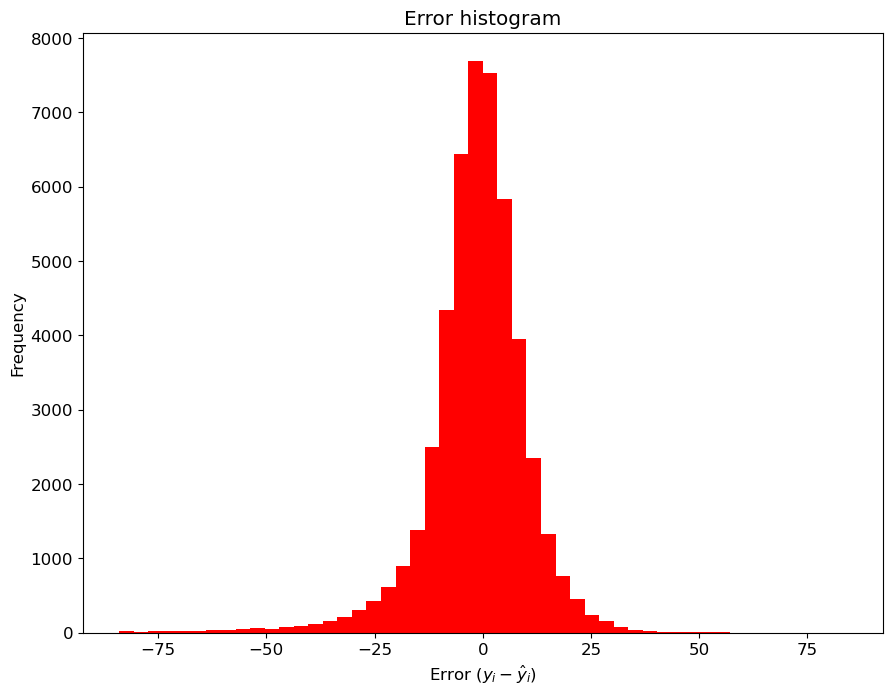

In [26]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])

# error histogram
error = y_fr - y_pred_fr

std = np.std(error)
print(f"The standard deviation is given by {std}")

hist = ax.hist(error, bins=50, range=(-84, +84), histtype="bar", color="red")

ax.set_title("Error histogram")
ax.set_xlabel(r"Error $(y_i - \hat{y}_i)$")
ax.set_ylabel("Frequency")
fig.savefig("error_history.png", bbox_inches="tight")

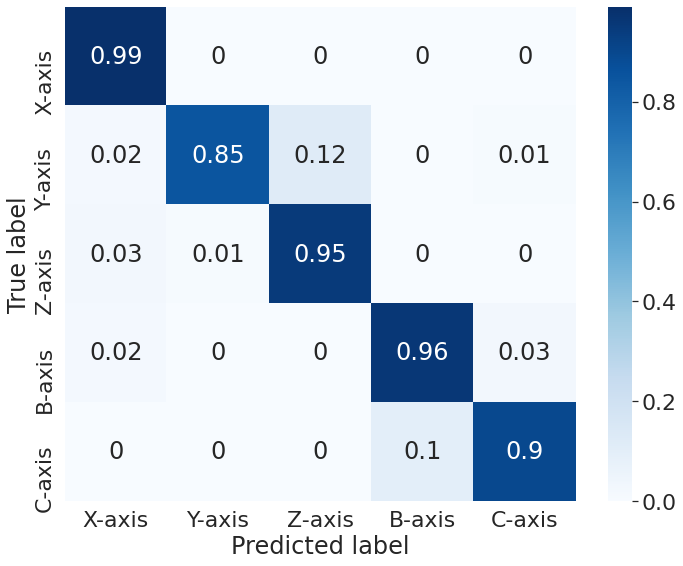

In [15]:
# Determining and plotting the confusion matrix
class_names = ["X-axis", "Y-axis", "Z-axis", "B-axis", "C-axis"]
con_mat = tf.math.confusion_matrix(labels=y_axis, predictions=y_pred_axis).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1) [:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)
figure = plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")

plt.savefig("conmat-temp.png", bbox_inches="tight")

In [16]:
# Extract the predicted feed rates 
results_df = pd.DataFrame({"axis_act": np.squeeze(y_axis), "fr_act": np.squeeze(y_fr), "axis_pred": np.squeeze(y_pred_axis), "fr_pred": np.squeeze(y_pred_fr)})
temp = results_df.groupby(by=["axis_act", "fr_act"])

plot_data = {}
checked_list = []
for index, group in enumerate(temp.groups.keys()):
    
    if group[0] not in checked_list:
        temp2 = temp.get_group(group)
        temp2 = temp2[temp2["axis_act"] == temp2["axis_pred"]]
        plot_data[group[0]] = np.array([[group[1], temp2["fr_pred"].mean()]])
        checked_list.append(group[0])
    else:
        temp2 = temp.get_group(group)
        temp2 = temp2[temp2["axis_act"] == temp2["axis_pred"]]
        plot_data[group[0]] = np.append(plot_data[group[0]], np.array([[group[1], temp2["fr_pred"].mean()]]), axis=0)

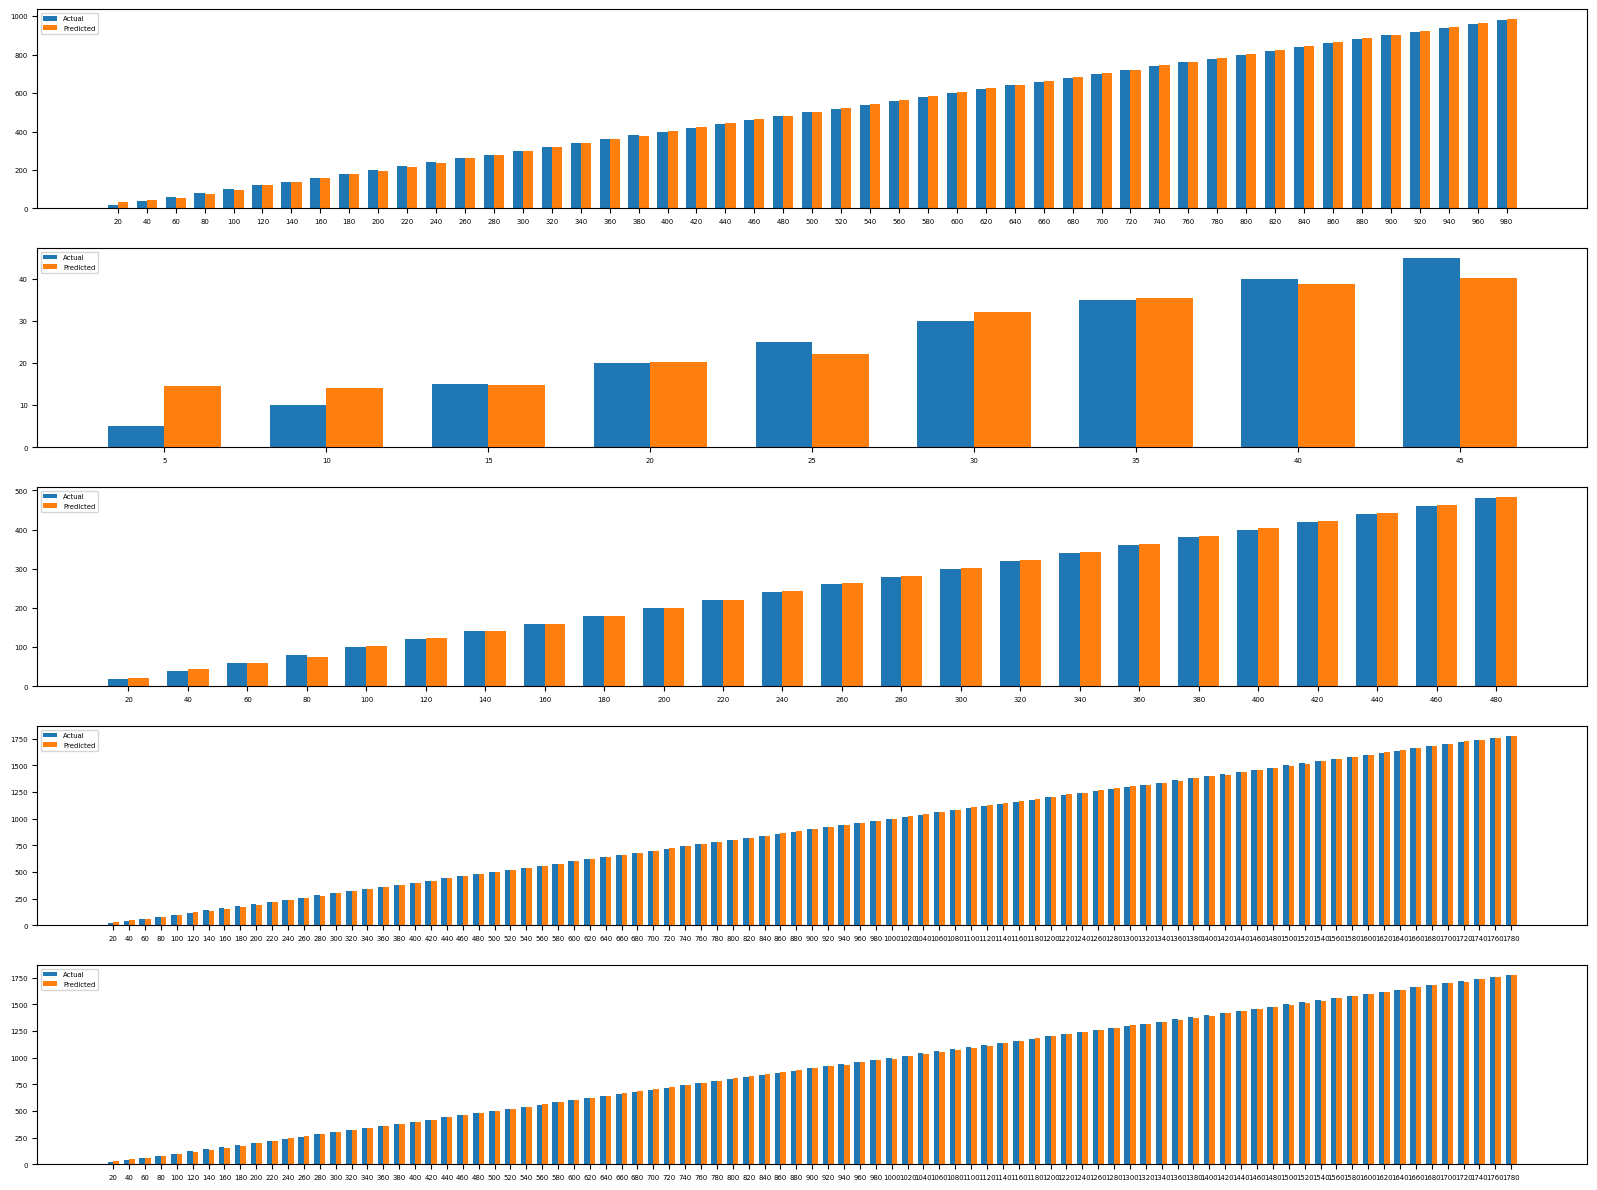

In [17]:
# Set the font properties
matplotlib.rcdefaults()
font = {'size'   : 5.0}
matplotlib.rc('font', **font)

# PLotting of the feed rate prediction
fig, axs = plt.subplots(5, 1, sharey=False, figsize=(20, 15))

for axis in sorted(plot_data.keys()):
    
    # Get the actual and predicted feed
    actual_feed = plot_data[axis][:, 0]
    predicted_feed = plot_data[axis][:, 1]
    labels = [str(round(x)) for x in actual_feed]
    
    # PLotting the bar chart
    x = np.arange(len(labels)) # the label locations
    width = 0.35 # the width of the bars 
    
    rects1 = axs[axis].bar(x - width/2, actual_feed, width, label="Actual")
    rects2 = axs[axis].bar(x + width/2, predicted_feed, width, label="Predicted")
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[axis].set_xticks(x)
    axs[axis].set_xticklabels(labels)
    axs[axis].legend(loc="upper left")
    
    fig.savefig("feed_rate_pred.png")

## CV fold evaluation

In [18]:
score_load_loc = os.path.join(os.getcwd(), "model_weights", "multi_output_ax-fr", folder_time, "training_history", "score.pickle")

# Load the data
with open(score_load_loc, "rb") as fhandle:
    scores = pickle.load(fhandle)


In [19]:
df = pd.DataFrame(scores, index=["cummulative_loss", "axis_detection_loss", "feed_rate_prediction_loss", "axis_detection_accuracy"])
df = df.transpose()

In [20]:
df

,cummulative_loss,axis_detection_loss,feed_rate_prediction_loss,axis_detection_accuracy
0,3259.358398,0.058710,157.046982,0.988711
1,3806.050049,0.055570,184.343201,0.988405
2,3209.129639,0.061870,154.517502,0.987069
3,3806.687500,0.055591,185.003983,0.989533
4,3670.109375,0.055653,177.875381,0.989130
5,3045.491943,0.056693,146.687317,0.988131
6,3405.476318,0.056145,164.369324,0.989597
7,3364.781982,0.058608,162.575821,0.988421
8,3912.464844,0.082676,190.311813,0.980337
9,3681.314697,0.060497,178.528824,0.987519


In [21]:
df.describe()

,cummulative_loss,axis_detection_loss,feed_rate_prediction_loss,axis_detection_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,3516.086475,0.060201,170.126015,0.987685
std,296.907343,0.008198,14.965935,0.002705
min,3045.491943,0.055570,146.687317,0.980337
25%,3285.714294,0.055776,158.429192,0.987672
50%,3537.792847,0.057650,171.122353,0.988413
75%,3774.866211,0.060050,182.889606,0.989025
max,3912.464844,0.082676,190.311813,0.989597


<AxesSubplot:>

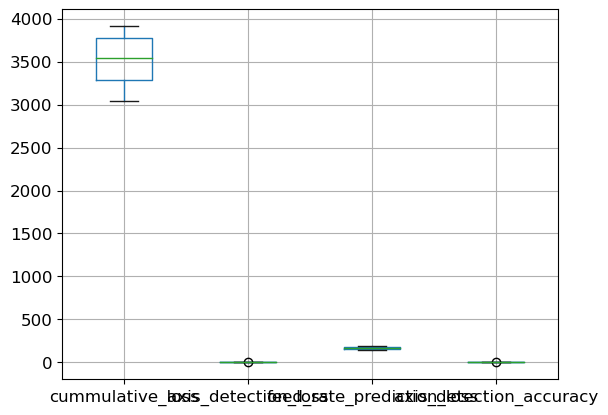

In [27]:
df.boxplot()